In [10]:
import numpy as np
from scipy.optimize import curve_fit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from persim import PersImage
import gudhi
import os
import glob
from matplotlib import ticker, cm
from matplotlib.colors import LogNorm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import time
from sklearn.decomposition import PCA
import matplotlib as mpl
from sklearn import preprocessing

In [11]:
#pdlocnum has format [[birth1, persistence1, counts1],...]
#bounds should be a list [bmin,bmax,pmin,pmax]
#bins should be a list [bbins, pbins]
def PerIm(pdlocnumI,bounds,bins,stdev,res=1000):
    if pdlocnumI % 1000 == 0:
        print(pdlocnumI)
    pdlocnum = pds[pdlocnumI]
    x = np.linspace(bounds[0], bounds[1], res)
    y = np.linspace(bounds[2], bounds[3], res)
    xx, yy = np.meshgrid(x, y, sparse=True)
    z=np.zeros([res,res])
    for i in np.arange(len(pdlocnum)):
        z=z+pdlocnum[i][1]*pdlocnum[i][2]*np.exp((-0.5*(xx-pdlocnum[i][0])**2-0.5*(yy-pdlocnum[i][1])**2)*stdev**-2)
    return z.reshape(bins[0],res//bins[0],bins[1],res//bins[1]).sum(3).sum(1)

In [13]:
fPD1list=np.sort(glob.glob("condorSims/Dat*/*/*PD1.dat"))
TPD1list=[]
for f in fPD1list:
    if f[39]=='\\':
        TPD1list.append(float(f[36:39]))
    else:
        TPD1list.append(float(f[36:40]))

In [ ]:
pds=[np.loadtxt(f) for f in fPD1list]

In [ ]:
bounds=[0,25,0,25]
bins=[25,25]
res=bins[0]*10

imgs1=[PerIm(p,bounds,bins,1,res=res) for p in np.arange(len(pds))]

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000


In [ ]:
t=50000
pd=pds[t]
bounds=[0,10,0,10]
bins=[10,10]
res=bins[0]*10

stdev=1

x = np.linspace(bounds[0], bounds[1], res)
y = np.linspace(bounds[2], bounds[3], res)
xx, yy = np.meshgrid(x, y, sparse=True)
z=np.zeros([res,res])
for i in np.arange(len(pd)):
    z=z+pd[i][1]*pd[i][2]*np.exp((-0.5*(xx-pd[i][0])**2-0.5*(yy-pd[i][1])**2)*stdev**-2)

plt.figure(figsize=(6,6))
plt.scatter(pd[:,0],pd[:,1],c='k')
plt.xlabel('b')
plt.ylabel('p')
plt.show()

plt.imshow(z,origin='lower')
plt.axis('off')
plt.show()

plt.imshow(PerIm(t,bounds,bins,stdev=stdev,res=res).reshape(bins),origin='lower')
plt.axis('off')
plt.show()

In [ ]:
imgs1_array=np.array([img.flatten() for img in imgs1])

In [ ]:
imgs1_scaled=preprocessing.scale(imgs1_array)

In [ ]:
labels=[int(t<2.519) for t in TPD1list]

In [ ]:
(np.shape(imgs1_array), np.shape(TPD1list), np.shape(labels))

In [ ]:
X_train, X_test, y_train, y_test, T_train, T_test = train_test_split(imgs1_scaled, labels, TPD1list, test_size=0.5)

In [ ]:
logreg = LogisticRegression(C=0.1, solver='liblinear', penalty='l2')
logreg.fit(X_train, y_train)

inverse_image = np.copy(logreg.coef_).reshape((25,25))
fig, ax = plt.subplots()
cs = ax.imshow(inverse_image, origin='lower')
cbar = fig.colorbar(cs)

In [ ]:
pred = logreg.predict(X_test)
diff = abs(pred-y_test)
TT = np.arange(1.0,3.51,0.05)
TT = np.round(TT, decimals=3)
avg = np.zeros(len(TT))
acc = np.zeros(len(TT))
for i in np.arange(len(TT)):
    avg[i] = np.mean(pred[np.where(T_test==TT[i])[0]])
    acc[i] = np.mean(1-diff[np.where(T_test==TT[i])[0]])

plt.plot(TT, acc)

In [ ]:
tRange = np.linspace(2,2.5,500)
interps = np.interp(tRange, TT, avg)

Tc = tRange[abs(interps-0.5).argmin()]

print(Tc)
plt.plot(tRange, interps)

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train)

In [ ]:
pred = kmeans.predict(X_test)
diff = abs(pred-y_test)
TT = np.arange(1.0,3.51,0.05)
TT = np.round(TT, decimals=3)
acc = np.zeros(len(TT))
avg = np.zeros(len(TT))
for i in np.arange(len(TT)):
    avg[i] = np.mean(pred[np.where(T_test==TT[i])[0]])
    acc[i] = np.mean(diff[np.where(T_test==TT[i])[0]])

plt.plot(TT, acc)

tRange = np.linspace(2,2.5,500)
interp = np.interp(tRange, TT, avg)

Tc = tRange[abs(interp-0.5).argmin()]
print(Tc)

In [ ]:
pca = PCA(n_components=2)
X_r = pca.fit(imgs1_array).transform(imgs1_array)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
cmap = plt.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(1.5,3,13)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
scat = ax.scatter([elm[0] for elm in X_r],[elm[1] for elm in X_r],c=TPD1list,s=0.1,cmap=cmap, norm=norm)
cbar = fig.colorbar(scat)
plt.show()

fig, ax = plt.subplots(1,1, figsize=(6,6))
cmap = plt.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0,1,3)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
scat = ax.scatter([elm[0] for elm in X_r],[elm[1] for elm in X_r],c=[1-l for l in labels],s=0.1,cmap=cmap, norm=norm)
plt.show()

**Power Law from PI**

In [124]:
def func(logr, a, xi, c):
    return c - np.exp(logr) / xi - a * logr

In [7]:
def getDensParams(im):
    dens=np.zeros(25)
    for r in range(len(dens)):
        for j in range(r+1):
            for k in range(r-j,25):
                dens[r] += im[j][k]
    plt.plot(dens)
    ydata=np.log(dens)
    rdata=np.log(np.arange(len(dens))+1)
    return curve_fit(func, rdata, ydata)[0]

In [9]:
rng=np.arange(0,len(imgs1),1)
params=np.array([getDensParams(imgs1[i]) for i in rng])
temps=[TPD1list[i] for i in rng]
plt.scatter(temps,params[:,1],marker='.',s=5)
plt.yscale('log')
plt.show()
plt.scatter(temps,params[:,2],marker='.',s=5)
plt.show()

ts=np.unique(temps)
aveXi=np.zeros(len(ts))
ave_a=np.zeros(len(ts))
for i in np.arange(len(ts)):
    aveXi[i] = np.exp(np.mean(np.log(params[np.where(temps==ts[i])[0]][:,1])))
    ave_a[i] = np.exp(np.mean(np.log(params[np.where(temps==ts[i])[0]][:,2])))
plt.plot(ts,aveXi)
plt.yscale('log')
plt.show()
plt.plot(ts,ave_a)
plt.show()

NameError: name 'imgs1' is not defined

In [244]:
ts[np.where(aveXi==np.max(aveXi))[0][0]]

2.35

**H0 Classification**

In [18]:
#pdlocnum has format [[birth1, persistence1, counts1],...]
#bounds should be a list [pmin,pmax]
#bins should be pbins
def PerIm0(pdlocnum,bounds,bins,stdev,res=1000):
    if len(np.shape(pdlocnum))==1:
        pdlocnum = np.array([pdlocnum])
    
    y = np.linspace(bounds[0], bounds[1], res)
    z=np.zeros(res)
    for i in np.arange(len(pdlocnum)):
        z=z+np.log(1+pdlocnum[i][1])*pdlocnum[i][2]*np.exp((-0.5*(y-pdlocnum[i][1])**2)*stdev**-2)
    return z.reshape(bins,res//bins).sum(1)

In [4]:
fPD0list=np.sort(glob.glob("condorSims/Dat*/*/*PD0.dat"))
TPD0list=[]
for f in fPD0list:
    if f[39]=='\\':
        TPD0list.append(float(f[36:39]))
    else:
        TPD0list.append(float(f[36:40]))

In [5]:
pds0=[np.loadtxt(f) for f in fPD0list]

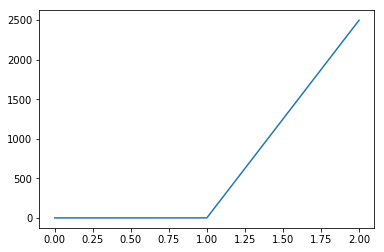

In [6]:
plt.plot(pds0[0])

In [21]:
bounds=[0,25]
bins=25
res=bins*10

imgs0 = [PerIm0(p,bounds,bins,1,res=res) for p in pds0]

In [22]:
imgs0_scaled=preprocessing.scale(imgs0)

In [418]:
labels0=[int(t<2.269) for t in TPD0list]

In [24]:
(np.shape(imgs0_scaled), np.shape(TPD0list), np.shape(labels0))

((71210, 25), (71210,), (71210,))

In [276]:
X_train, X_test, y_train, y_test, T_train, T_test = train_test_split(imgs0_scaled, labels, TPD0list, test_size=0.50)

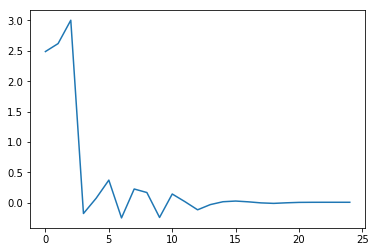

In [287]:
logreg = LogisticRegression(C=0.1, solver='liblinear', penalty='l2')
logreg.fit(X_train, y_train)

inverse_image = np.copy(logreg.coef_)
plt.plot(inverse_image[0])

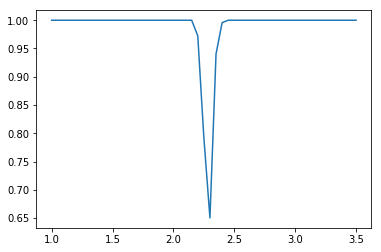

In [288]:
pred = logreg.predict(X_test)
diff = abs(pred-y_test)
TT = np.arange(1.0,3.51,0.05)
TT = np.round(TT, decimals=3)
avg = np.zeros(len(TT))
acc = np.zeros(len(TT))
for i in np.arange(len(TT)):
    avg[i] = np.mean(pred[np.where(T_test==TT[i])[0]])
    acc[i] = np.mean(1-diff[np.where(T_test==TT[i])[0]])

plt.plot(TT, acc)

2.282565130260521


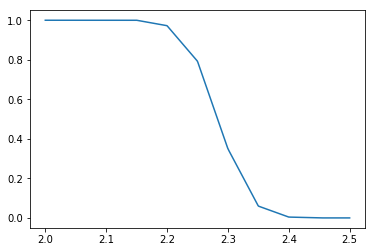

In [289]:
tRange = np.linspace(2,2.5,500)
interps = np.interp(tRange, TT, avg)

Tc = tRange[abs(interps-0.5).argmin()]

print(Tc)
plt.plot(tRange, interps)

In [290]:
kmeans = KMeans(n_clusters=2, random_state=10).fit(X_train)

2.3266533066132267


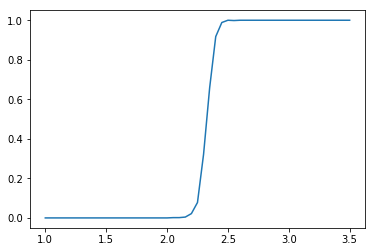

In [291]:
pred = kmeans.predict(X_test)
TT = np.arange(1.0,3.51,0.05)
TT = np.round(TT, decimals=3)
avg = np.zeros(len(TT))
for i in np.arange(len(TT)):
    avg[i] = np.mean(pred[np.where(T_test==TT[i])[0]])

plt.plot(TT, avg)

tRange = np.linspace(2,2.5,500)
interp = np.interp(tRange, TT, avg)

Tc = tRange[abs(interp-0.5).argmin()]
print(Tc)

In [285]:
pca = PCA(n_components=2)
X_r = pca.fit(imgs0).transform(imgs0)

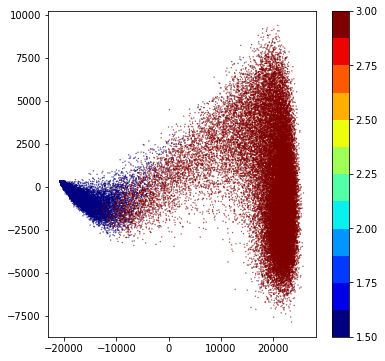

In [426]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
cmap = plt.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(1.5,3,13)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
scat = ax.scatter([elm[0] for elm in X_r],[elm[1] for elm in X_r],c=[3-1.5*l for l in labels],s=0.1,cmap=cmap, norm=norm)
cbar = fig.colorbar(scat)
plt.show()